# goals
* explore the mismatch between lensed and RP waveforms
* explore the conditions for indistinguishable waveforms

# import modules

In [1]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver0 import *
from modules.default_params_ver0 import *
from modules.functions_ver0 import *

# define Classes & methods

**Note: this notebook uses the wave optics (Lensing class), not the geometric optics (LensingGeo class).**

In [4]:
# override the integrand_delta_phi function in the Precessing class

### get the delta phi_P
def integrand_delta_phi_here(self, y, f):
    """integrand for delta phi p (equations in Apostolatos 1994, and appendix of Evangelos in prep)"""
    LdotN = self.LdotN(f)
    cos_i_JN, sin_i_JN, cos_o_XH, sin_o_XH = self.precession_angles()
    f_dot = self.f_dot(f)

    Omega_LJ = (
        1000
        * self.omega_tilde
        * (f / self.f_cut()) ** (5 / 3)
        / (self.total_mass() / self.SOLMASS2SEC)
    )

    integrand_delta_phi = (
        (LdotN / (1 - LdotN**2))
        * Omega_LJ
        * np.sin(self.theta_LJ(f))
        * (
            np.cos(self.theta_LJ(f)) * sin_i_JN * np.sin(self.phi_LJ(f))
            - np.sin(self.theta_LJ(f)) * cos_i_JN
        )
        / f_dot
    )

    # if self.theta_tilde == 0:
        # integrand_delta_phi = - Omega_LJ  # should be 0 here?!

    if cos_i_JN == 1:
        integrand_delta_phi = -Omega_LJ * np.cos(self.theta_LJ(f)) / f_dot

    # if LdotN == 1:
        # integrand_delta_phi = 0

    return integrand_delta_phi

Precessing.integrand_delta_phi = integrand_delta_phi_here

In [ ]:
lensing_params, RP_params, NP_params = set_to_params(lensing_params_0, RP_params_0, NP_params_0)

# define contour plot function

In [11]:
# general function to plot contours
def plot_contour(Z_func, X, Y, n_pts, x_label, y_label, z_label, title):
    # calculate Z values
    Z = np.zeros_like(X)
    for i in range(n_pts):
        for j in range(n_pts):
            Z[i, j] = Z_func(X[i, j], Y[i, j])

    # plot the contour
    plt.contourf(X, Y, Z, levels=40, cmap='viridis')
    plt.colorbar(label=z_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

# inclination contours

## specific functions

In [12]:
def inclination_cosine(phi_J, theta_J, phi_S, theta_S):
    # calculate cosine of inclination angle between J and N
    cos_i_JN = np.cos(theta_J) * np.cos(theta_S) + np.sin(theta_J) * np.sin(theta_S) * np.cos(phi_J - phi_S)
    return cos_i_JN

def inclination_contour(phi_S, theta_S):
    # contour plot of inclination angle between J and N as a function of theta_J and phi_J
    n_pts = 100
    phi_J_mesh = np.linspace(0, 2*np.pi, n_pts)
    theta_J_mesh = np.linspace(0, np.pi, n_pts)
    X, Y = np.meshgrid(phi_J_mesh, theta_J_mesh)
    Z = inclination_cosine(X, Y, phi_S, theta_S)
    plt.contourf(X, np.cos(Y), Z, levels=40, cmap='viridis')
    plt.colorbar(label = r'$\cos \iota_{JN}$')
    plt.ylabel(r'$\cos \theta_J$')
    plt.xlabel(r'$\phi_J$')
    plt.xticks(np.arange(0, 2*np.pi + np.pi/4, np.pi/4), [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$', r'$2\pi$'])
    plt.title(r'inclination contour at $\phi_S$ = {:.3g}, $\theta_S$ = {:.3g}'.format(phi_S, theta_S))

In [13]:
def find_FaceOn_coordinates_J(phi_S, theta_S):
    # find the face-on J coordinates where abs(cos_i_JN) = 1
    n_pts = 100
    phi_J_mesh = np.linspace(0, 2*np.pi, n_pts)
    theta_J_mesh = np.linspace(0, np.pi, n_pts)
    X, Y = np.meshgrid(phi_J_mesh, theta_J_mesh)
    Z = inclination_cosine(X, Y, phi_S, theta_S)
    # condition where Z = 1 within error
    cond = np.isclose(np.abs(Z), 1, rtol=0, atol=1e-3)
    # get phi_J, theta_J where condition is True
    return X[cond], Y[cond]

def find_EdgeOn_coordinates_J(phi_S, theta_S):
    # find the edge-on J coordinates where cos_i_JN = 0
    n_pts = 100
    phi_J_mesh = np.linspace(0, 2*np.pi, n_pts)
    theta_J_mesh = np.linspace(0, np.pi, n_pts)
    X, Y = np.meshgrid(phi_J_mesh, theta_J_mesh)
    Z = inclination_cosine(X, Y, phi_S, theta_S)
    # condition where Z = 0 within error
    cond = np.isclose(np.abs(Z), 0, rtol=0, atol=1e-2)
    # get phi_J, theta_J where condition is True
    return X[cond], Y[cond]

def scatter_special_coords(phi_S, theta_S):
    phi_J_FaceOn, theta_J_FaceOn = find_FaceOn_coordinates_J(phi_S, theta_S)
    plt.scatter(phi_J_FaceOn, np.cos(theta_J_FaceOn), s=1, c='grey', label='face-on')
    phi_J_EdgeOn, theta_J_EdgeOn = find_EdgeOn_coordinates_J(phi_S, theta_S)
    plt.scatter(phi_J_EdgeOn, np.cos(theta_J_EdgeOn), s=1, c='black', label='edge-on')
    plt.legend(bbox_to_anchor=(1.2, 1.2), loc='upper left', borderaxespad=0.)

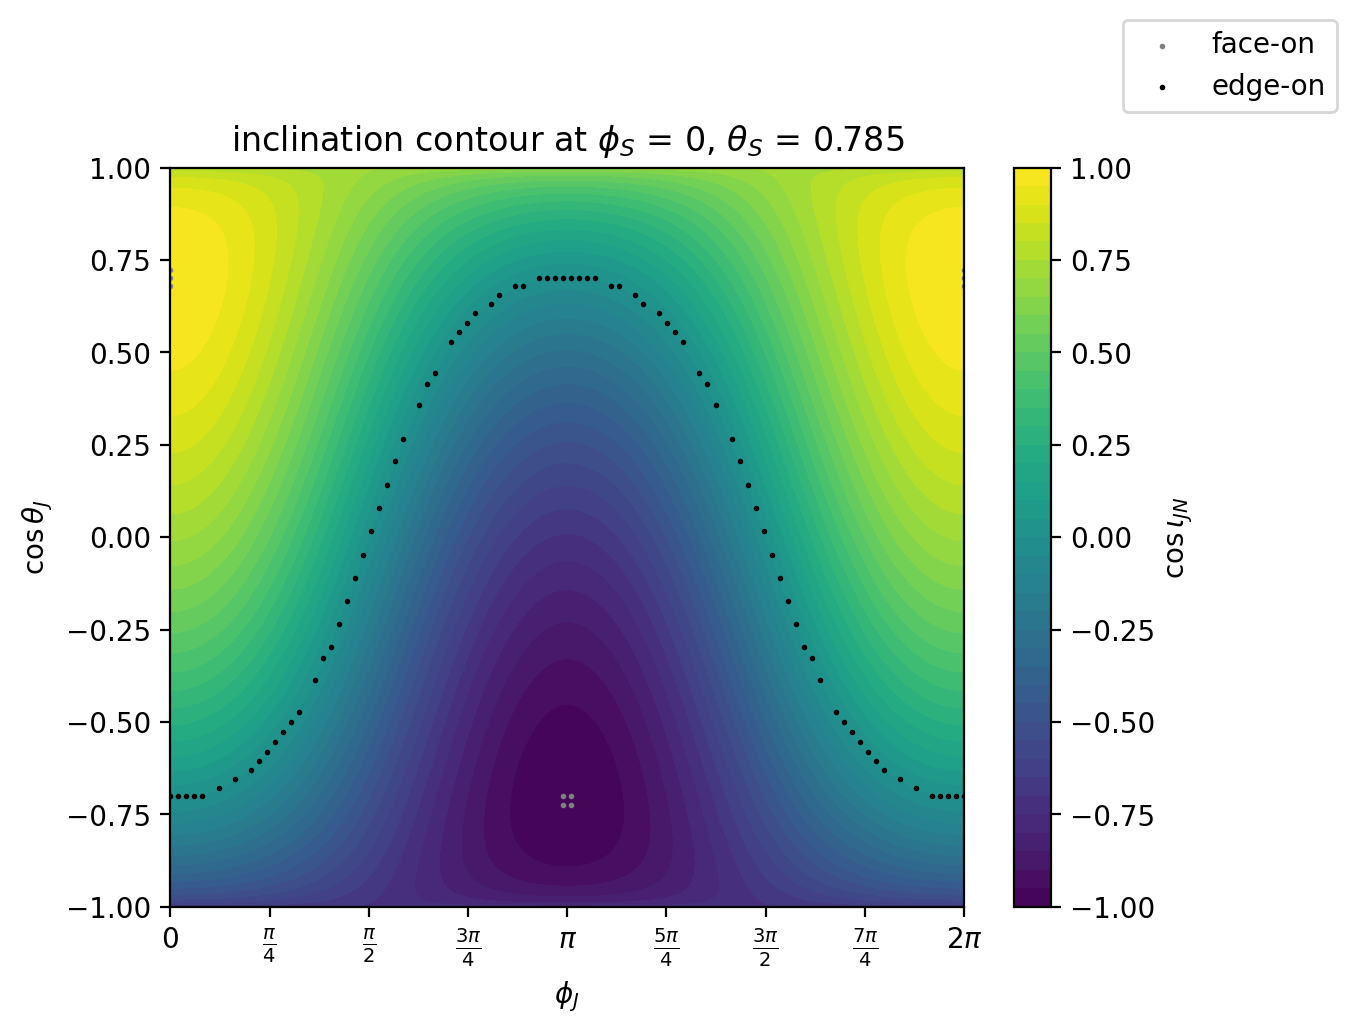

In [14]:
phi_S = 0
theta_S = np.pi/4

inclination_contour(phi_S, theta_S)
scatter_special_coords(phi_S, theta_S)

In [15]:
phi_S_range = widgets.FloatSlider(min=0, max=2*np.pi, step=np.pi/4, value=0, description='phi_S')
theta_S_range = widgets.FloatSlider(min=0, max=np.pi, step=np.pi/12, value=np.pi/4, description='theta_S')

def slider_plot_inclination_w_special_coords(phi_S, theta_S):
    inclination_contour(phi_S, theta_S)
    scatter_special_coords(phi_S, theta_S)

interact(slider_plot_inclination_w_special_coords, phi_S=phi_S_range, theta_S=theta_S_range)

interactive(children=(FloatSlider(value=0.0, description='phi_S', max=6.283185307179586, step=0.78539816339744…

<function __main__.slider_plot_inclination_w_special_coords(phi_S, theta_S)>

## general functions

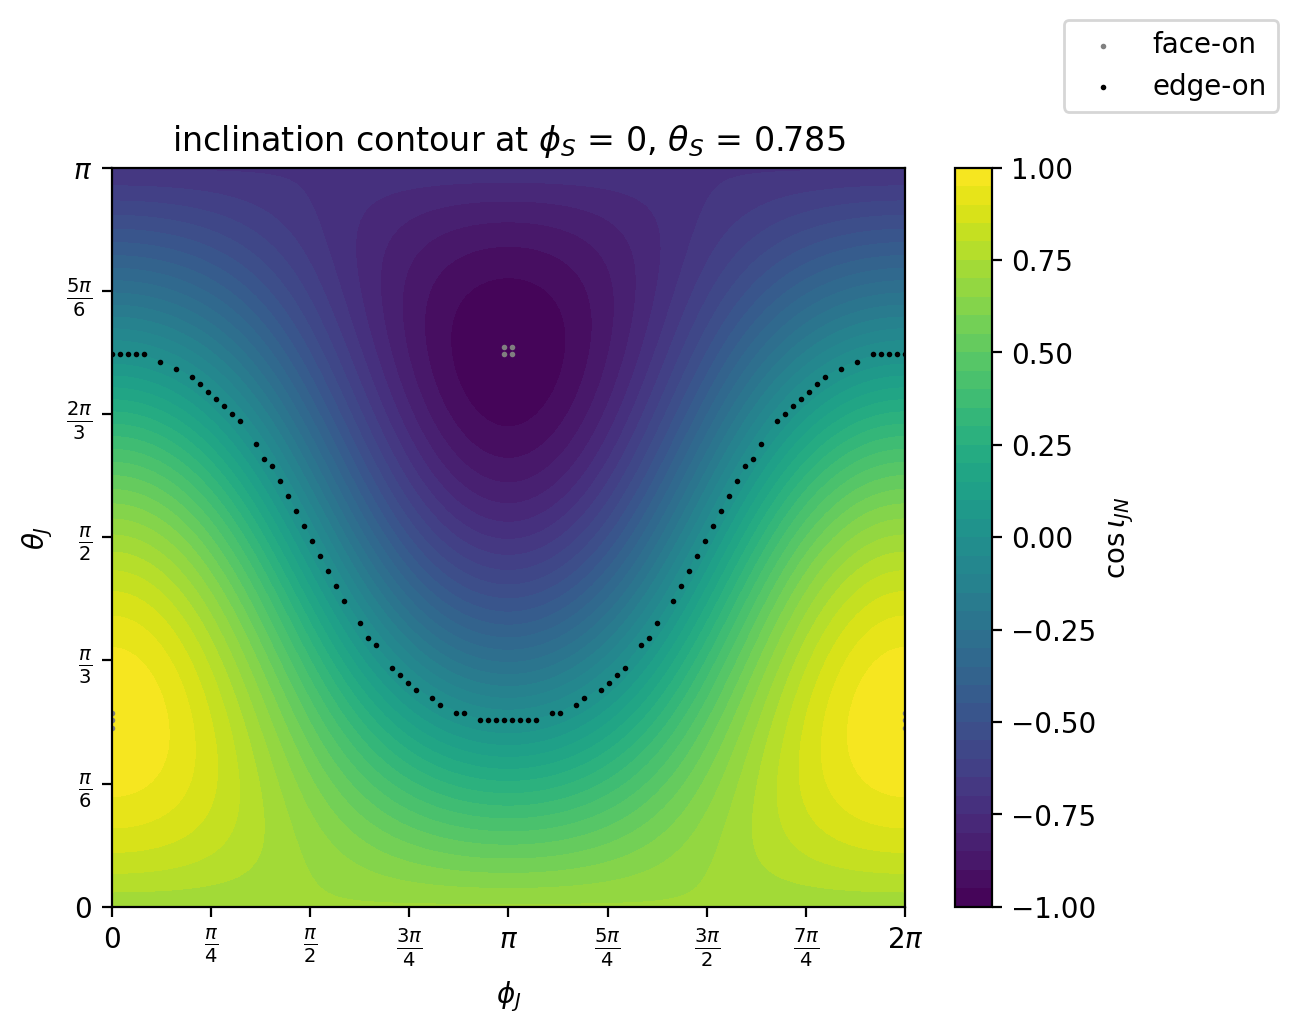

In [16]:
n_pts = 100
phi_J_mesh = np.linspace(0, 2*np.pi, n_pts)
theta_J_mesh = np.linspace(0, np.pi, n_pts)
X, Y = np.meshgrid(phi_J_mesh, theta_J_mesh)
phi_S = 0
theta_S = np.pi/4

# plot inclination contour using plot_contour function
plot_contour(lambda phi_J, theta_J: inclination_cosine(phi_J, theta_J, phi_S, theta_S), X, Y, n_pts, r'$\phi_J$', r'$\theta_J$', r'$\cos \iota_{JN}$', r'inclination contour at $\phi_S$ = {:.3g}, $\theta_S$ = {:.3g}'.format(phi_S, theta_S))
plt.xticks(np.arange(0, 2*np.pi + np.pi/4, np.pi/4), [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$', r'$2\pi$'])
plt.yticks(np.arange(0, np.pi + np.pi/6, np.pi/6), [r'$0$', r'$\frac{\pi}{6}$', r'$\frac{\pi}{3}$', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\frac{5\pi}{6}$', r'$\pi$'])

# plot special coordinates
phi_J_FaceOn, theta_J_FaceOn = find_FaceOn_coordinates_J(phi_S, theta_S)
plt.scatter(phi_J_FaceOn, theta_J_FaceOn, s=1, c='grey', label='face-on')
phi_J_EdgeOn, theta_J_EdgeOn = find_EdgeOn_coordinates_J(phi_S, theta_S)
plt.scatter(phi_J_EdgeOn, theta_J_EdgeOn, s=1, c='black', label='edge-on')
plt.legend(bbox_to_anchor=(1.2, 1.2), loc='upper left', borderaxespad=0.);

# SNR contours

## compare multiple SNR calculations

In [25]:
def SNR_1(Class_name, params):
    Class = eval(Class_name)
    Class_init = Class(params)
    f_cut = Class_init.f_cut()
    f_min = 20
    delta_f = 0.25
    f_range = np.arange(f_min, f_cut, delta_f)
    psd_n = Sn(f_range)
    h = Class_init.strain(f_range, delta_f=delta_f)

    # calculate SNR
    integrand = np.conj(h) * h / psd_n
    integrated_inner_product = simps(integrand, f_range)
    SNR = np.sqrt(4 * np.real(integrated_inner_product))

    return SNR

In [26]:
def SNR_2(Class_name, params):
    Class = eval(Class_name)
    Class_init = Class(params)
    f_cut = Class_init.f_cut()
    f_min = 20
    delta_f = 0.25
    f_range = np.arange(f_min, f_cut, delta_f)
    psd_n = Sn(f_range)
    h = Class_init.strain(f_range, delta_f=delta_f)

    # calculate SNR
    integrand = np.abs(h)**2 / psd_n
    integrated_inner_product = simps(integrand, f_range)
    SNR = np.sqrt(4 * np.real(integrated_inner_product))

    return SNR

In [27]:
def SNR_3(Class_name, params):
    Class = eval(Class_name)
    Class_init = Class(params)
    f_cut = Class_init.f_cut()
    f_min = 20
    delta_f = 0.25
    f_range = np.arange(f_min, f_cut, delta_f)
    psd_n = Sn(f_range)
    h = Class_init.strain(f_range, delta_f=delta_f)

    # calculate SNR
    integrand = np.conj(h) * h / psd_n
    integrand_real = np.real(integrand)
    integrated_inner_product = simps(integrand_real, f_range)
    SNR = np.sqrt(4 * np.real(integrated_inner_product))

    return SNR

In [31]:
def SNR_4(Class, params):
    Class_init = Class(params)
    f_cut = Class_init.f_cut()
    f_min = 20
    delta_f = 0.25
    f_range = np.arange(f_min, f_cut, delta_f)
    psd_n = Sn(f_range)
    h = Class_init.strain(f_range, delta_f=delta_f)

    # calculate SNR
    integrand = np.abs(h)**2 / psd_n
    integrated_inner_product = simps(integrand, f_range)
    SNR = np.sqrt(4 * np.real(integrated_inner_product))

    return SNR

In [32]:
lensing_params = lensing_params_0.copy()

# compare SNR calculated using different methods
print(SNR_1('Lensing', lensing_params))
print(SNR_2('Lensing', lensing_params))
# print(SNR_3('Lensing', lensing_params))
print(SNR_4(Lensing, lensing_params))

14.197328827531486
14.197328827531486
14.197328827531486


## plot SNR contours

### functions ver1

In [21]:
# assign SNR_2 function to a function named SNR
SNR = SNR_2

In [22]:
def SNR_contour_ver1(Class_name, params, phi_S, theta_S):
    # contour plot of SNR as a function of theta_J and phi_J
    params['phi_S'] = phi_S
    params['theta_S'] = theta_S

    n_pts = 100
    phi_J_mesh = np.linspace(0, 2*np.pi, n_pts)
    theta_J_mesh = np.linspace(0, np.pi, n_pts)
    X, Y = np.meshgrid(phi_J_mesh, theta_J_mesh)
    Z = np.zeros_like(X)

    for i in range(n_pts):
        for j in range(n_pts):
            if Class_name == 'Lensing':
                params['theta_L'] = theta_J_mesh[i]
                params['phi_L'] = phi_J_mesh[j]
            elif Class_name == 'Precessing':
                params['theta_J'] = theta_J_mesh[i]
                params['phi_J'] = phi_J_mesh[j]
            
            Z[i, j] = SNR(Class_name, params)
    
    plt.contourf(X, np.cos(Y), Z, levels=40, cmap='viridis')
    plt.colorbar(label = r'$\rho$')
    plt.ylabel(r'$\cos \theta_J$')
    plt.xlabel(r'$\phi_J$')
    plt.xticks(np.arange(0, 2*np.pi + np.pi/4, np.pi/4), [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$', r'$2\pi$'])
    plt.title(Class_name + r' SNR contour at $\phi_S$ = {:.3g}, $\theta_S$ = {:.3g}'.format(phi_S, theta_S))

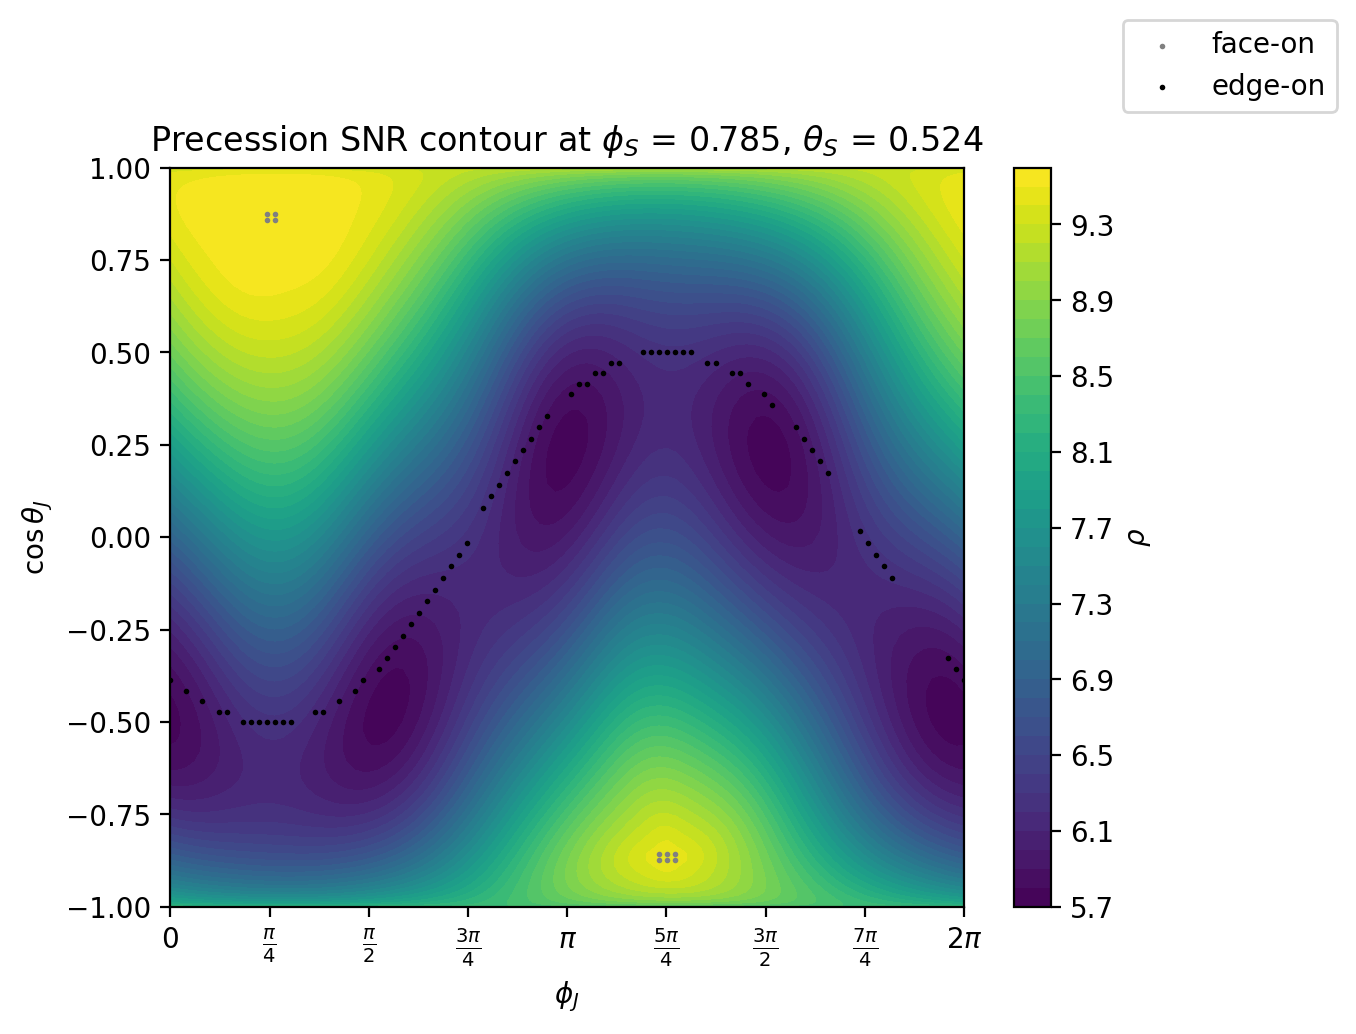

In [23]:
# plot SNR contour for precessing
RP_params = RP_params_0.copy()

phi_S = np.pi/4
theta_S = np.pi/6
RP_params['theta_tilde'] = 8
RP_params['omega_tilde'] = 3

SNR_contour_ver1('Precessing', RP_params, phi_S, theta_S)
scatter_special_coords(phi_S, theta_S)

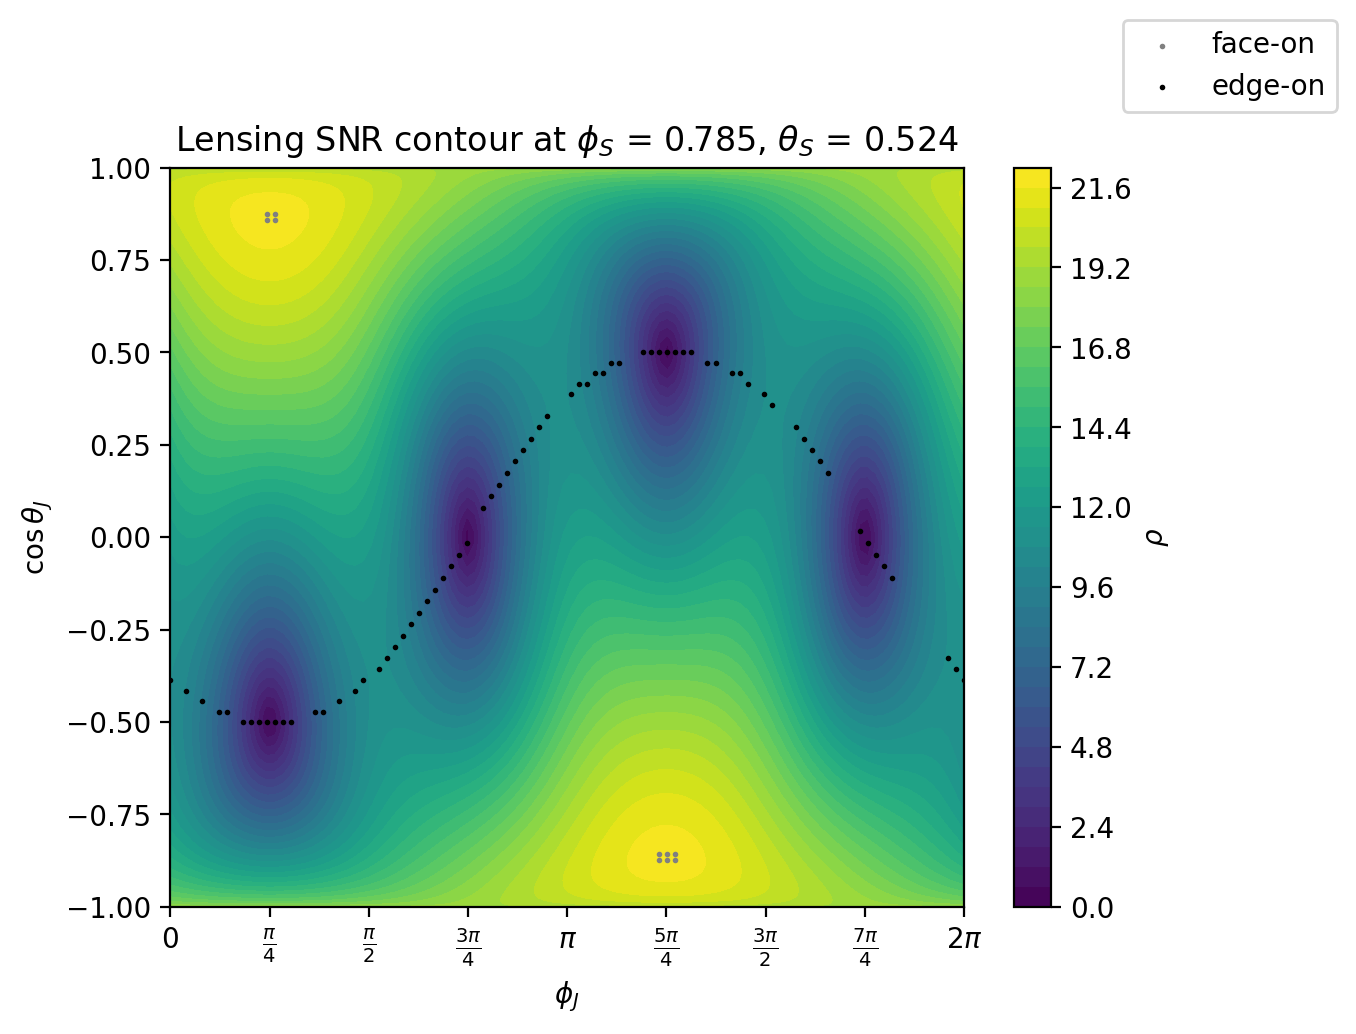

In [24]:
# plot SNR contour for lensing
lensing_params = lensing_params_0.copy()

phi_S = np.pi/4
theta_S = np.pi/6
lensing_params['MLz'] = 1000 * solar_mass
lensing_params['y'] = 0.25

SNR_contour_ver1('Lensing', lensing_params, phi_S, theta_S)
scatter_special_coords(phi_S, theta_S)

### functions ver2

In [33]:
# assign SNR_4 function to a function named SNR
SNR = SNR_4

In [38]:
def SNR_contour_ver2(Class, params, phi_S, theta_S):
    # contour plot of SNR as a function of theta_J and phi_J
    params['phi_S'] = phi_S
    params['theta_S'] = theta_S

    n_pts = 100
    phi_J_mesh = np.linspace(0, 2*np.pi, n_pts)
    theta_J_mesh = np.linspace(0, np.pi, n_pts)
    X, Y = np.meshgrid(phi_J_mesh, theta_J_mesh)
    Z = np.zeros_like(X)

    for i in range(n_pts):
        for j in range(n_pts):
            if Class == Lensing:
                params['theta_L'] = theta_J_mesh[i]
                params['phi_L'] = phi_J_mesh[j]
            elif Class == Precessing:
                params['theta_J'] = theta_J_mesh[i]
                params['phi_J'] = phi_J_mesh[j]
            
            Z[i, j] = SNR(Class, params)
    
    plt.contourf(X, np.cos(Y), Z, levels=40, cmap='viridis')
    plt.colorbar(label = r'$\rho$')
    plt.ylabel(r'$\cos \theta_J$')
    plt.xlabel(r'$\phi_J$')
    plt.xticks(np.arange(0, 2*np.pi + np.pi/4, np.pi/4), [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$', r'$2\pi$'])
    plt.title(Class.__name__ + r' SNR contour at $\phi_S$ = {:.3g}, $\theta_S$ = {:.3g}'.format(phi_S, theta_S))

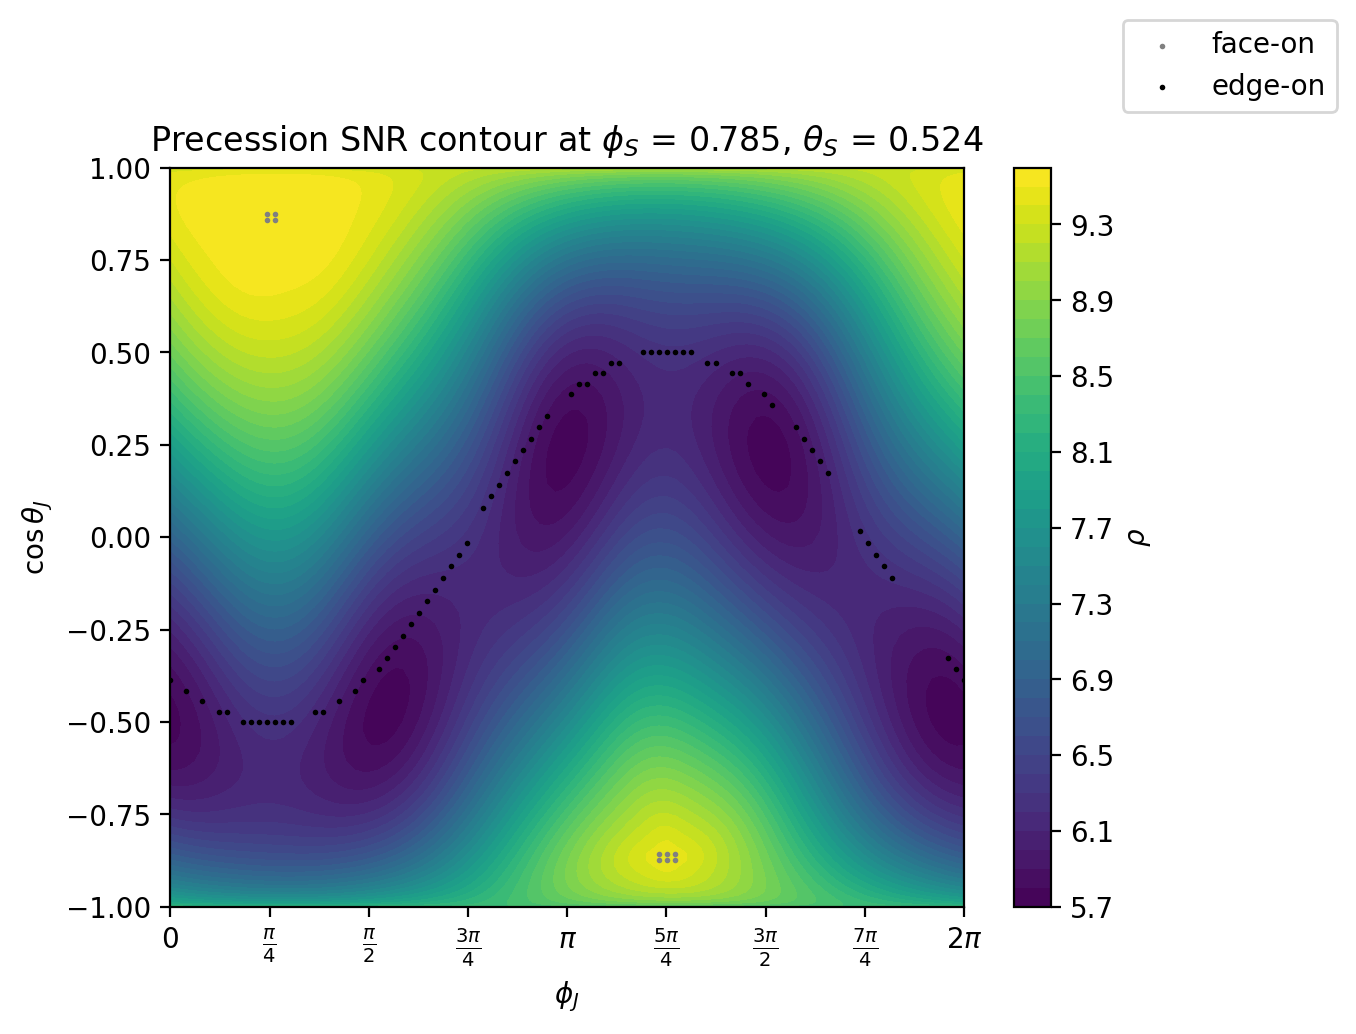

In [39]:
# plot SNR contour for precessing
RP_params = RP_params_0.copy()

phi_S = np.pi/4
theta_S = np.pi/6
RP_params['theta_tilde'] = 8
RP_params['omega_tilde'] = 3

SNR_contour_ver2(Precessing, RP_params, phi_S, theta_S)
scatter_special_coords(phi_S, theta_S)

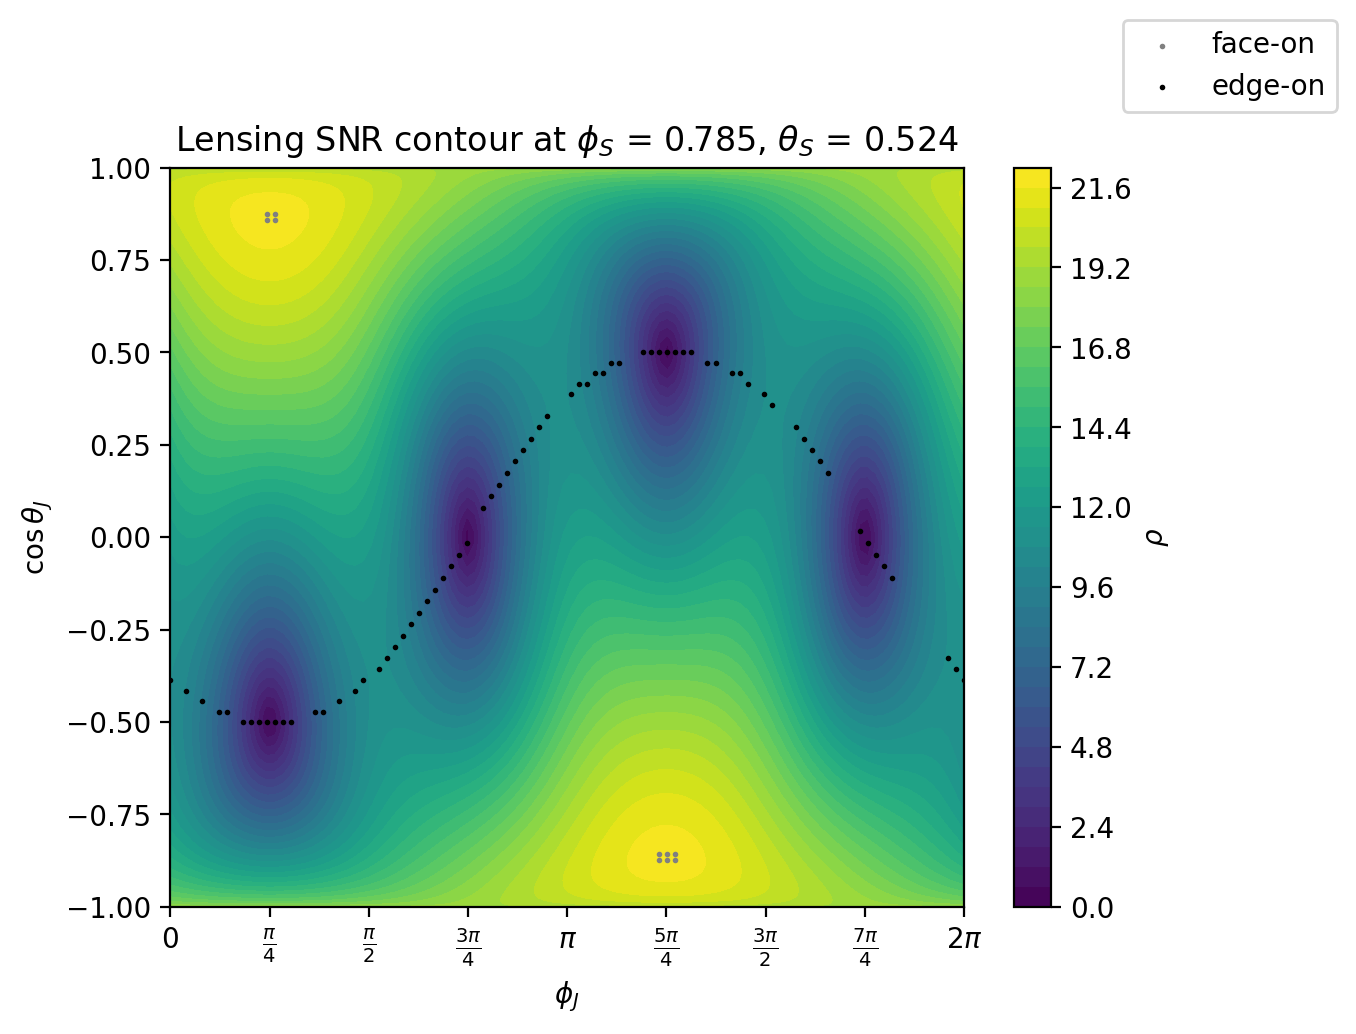

In [40]:
# plot SNR contour for lensing
lensing_params = lensing_params_0.copy()

phi_S = np.pi/4
theta_S = np.pi/6
lensing_params['MLz'] = 1000 * solar_mass
lensing_params['y'] = 0.25

SNR_contour_ver2(Lensing, lensing_params, phi_S, theta_S)
scatter_special_coords(phi_S, theta_S)

# mismatch between L & RP with RP fixed

In [333]:
# plot contour of mismatch between L & RP as a function of MLz and y

def mismatch_contour_L_RP(lensing_params, RP_params):
    # save function output to a figure
    fig = plt.figure(figsize=(10, 6))

    n_pts = 30
    MLz_mesh = np.linspace(500, 6000, n_pts)
    y_mesh = np.linspace(0.1, 3, n_pts)
    X, Y = np.meshgrid(MLz_mesh, y_mesh)
    Z = np.zeros_like(X)

    for i in range(n_pts):
        for j in range(n_pts):
            lensing_params['MLz'] = MLz_mesh[i] * solar_mass
            lensing_params['y'] = y_mesh[j]
            ep_min, g_min, ep_max, g_max, ep_0 = mismatch_epsilon_min_max(lensing_params, RP_params, NP_params, 'L & RP')
            Z[i, j] = ep_min
    
    plt.contourf(X, Y, Z, levels=40, cmap='viridis')
    plt.xlabel(r'$M_{Lz}$')
    plt.ylabel(r'$y$')
    plt.colorbar(label=r'$\epsilon$', cmap='viridis', norm=colors.Normalize(vmin=0, vmax=1))
    plt.title(r'$\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, $\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, {} = {:.3g}, {} = {:.3g}'.format(RP_params['theta_J'], RP_params['phi_J'], RP_params['theta_S'], RP_params['phi_S'], r'$\tilde{\theta}$', RP_params['theta_tilde'], r'$\tilde{\Omega}$', RP_params['omega_tilde']))

    return fig

## face-on

In [334]:
lensing_params = lensing_params_0.copy()
RP_params = RP_params_0.copy()

# using Saif's choice of sky locations, set sky location to face-on
theta_J = theta_S = np.pi/6
phi_J = phi_S = np.pi/4
print('inclination_cosine =', inclination_cosine(phi_J, theta_J, phi_S, theta_S))

# set lensed & RP to same location
lensing_params['theta_L'] = RP_params['theta_J'] = theta_J
lensing_params['phi_L'] = RP_params['phi_J'] = phi_J
lensing_params['theta_S'] = RP_params['theta_S'] = theta_S
lensing_params['phi_S'] = RP_params['phi_S'] = phi_S

# set mcz for both lensed and RP
mcz = 50
lensing_params['mcz'] = RP_params['mcz'] = mcz * solar_mass

inclination_cosine = 1.0


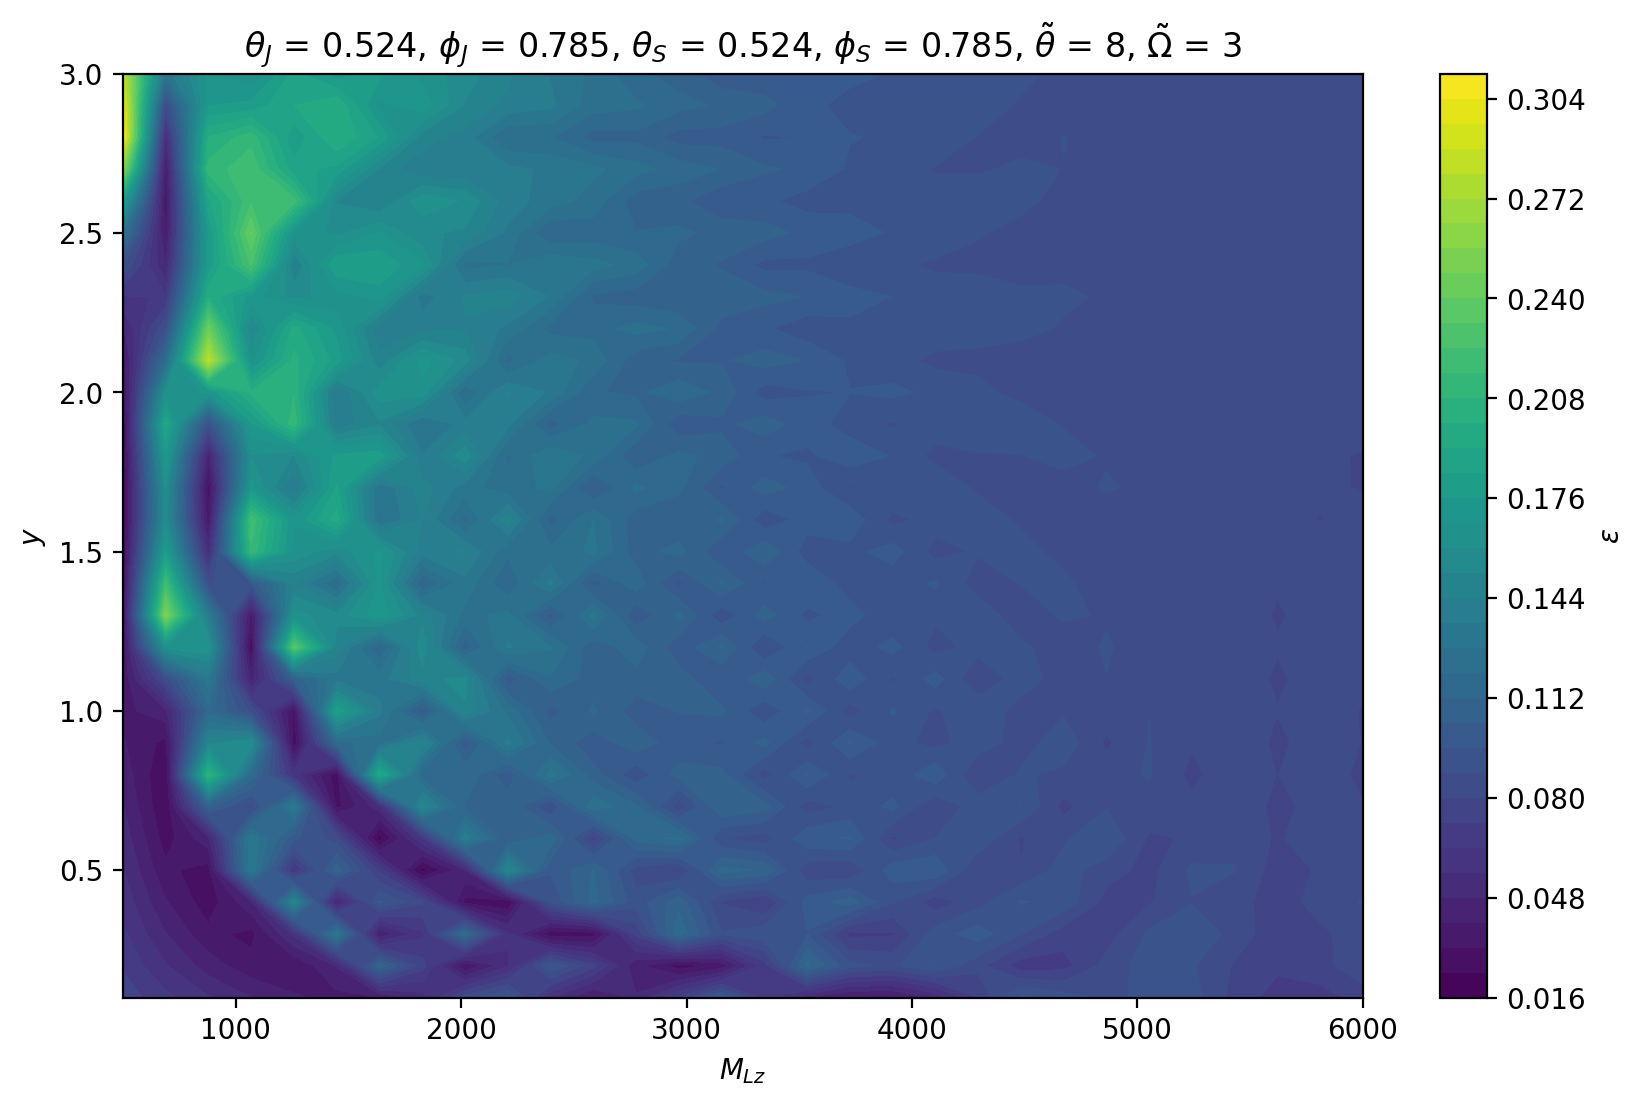

In [335]:
theta_omega_pairs = [(1, 1), (4, 2), (8, 3)][-1:]

for i, (theta_tilde, omega_tilde) in enumerate(theta_omega_pairs):
    RP_params['theta_tilde'] = theta_tilde
    RP_params['omega_tilde'] = omega_tilde
    fig = mismatch_contour_L_RP(lensing_params, RP_params)
    fig.savefig('figures/mismatch_contour_L_RP_FaceOn_{}_{}.png'.format(theta_tilde, omega_tilde))

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
# fig.subplots_adjust(hspace=.5)
# fig.subplots_adjust(wspace=.5)

# for i in range(3):
#     axes[i].imshow(mpimg.imread('figures/mismatch_contour_L_RP_{}.png'.format(i)))
#     axes[i].axis('off')

# fig.suptitle('Mismatch contour between L & RP', fontsize=16)

## edge-on

In [336]:
lensing_params = lensing_params_0.copy()
RP_params = RP_params_0.copy()

# using Saif's choice of sky locations, set sky location to edge-on
theta_J = 2*np.pi/3
phi_J = np.pi/3
theta_S = np.pi/6
phi_S = np.pi/3
print('inclination_cosine =', inclination_cosine(phi_J, theta_J, phi_S, theta_S))

# set lensed & RP to same location
lensing_params['theta_L'] = RP_params['theta_J'] = theta_J
lensing_params['phi_L'] = RP_params['phi_J'] = phi_J
lensing_params['theta_S'] = RP_params['theta_S'] = theta_S
lensing_params['phi_S'] = RP_params['phi_S'] = phi_S

# set mcz for both lensed and RP
mcz = 50
lensing_params['mcz'] = RP_params['mcz'] = mcz * solar_mass

inclination_cosine = 1.1102230246251565e-16


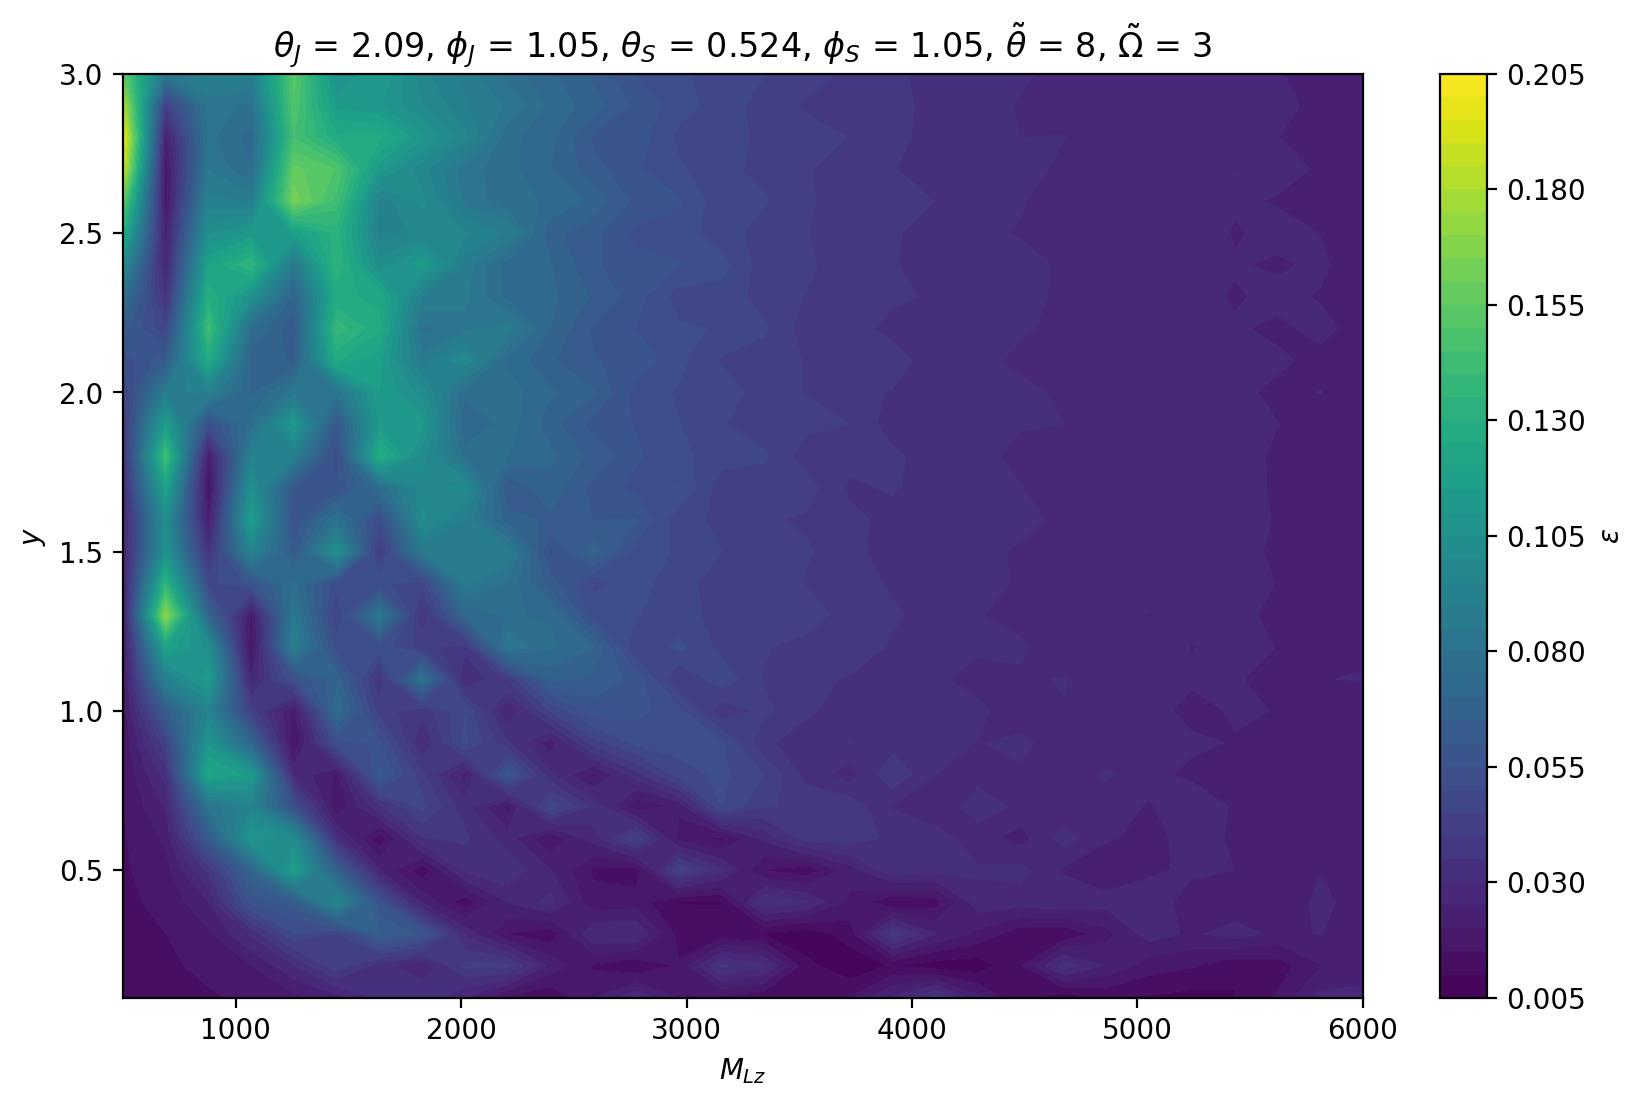

In [337]:
theta_omega_pairs = [(1, 1), (4, 2), (8, 3)][-1:]

for i, (theta_tilde, omega_tilde) in enumerate(theta_omega_pairs):
    RP_params['theta_tilde'] = theta_tilde
    RP_params['omega_tilde'] = omega_tilde
    fig = mismatch_contour_L_RP(lensing_params, RP_params)
    fig.savefig('figures/mismatch_contour_L_RP_EdgeOn_{}_{}.png'.format(theta_tilde, omega_tilde))

## random

In [ ]:
lensing_params = lensing_params_0.copy()
RP_params = RP_params_0.copy()

# using Saif's choice of sky locations, set sky location to random
theta_J = np.pi/3
phi_J = np.pi/4
theta_S = 0
phi_S = np.pi/4
print('inclination_cosine =', inclination_cosine(phi_J, theta_J, phi_S, theta_S))

# set lensed & RP to same location
lensing_params['theta_L'] = RP_params['theta_J'] = theta_J
lensing_params['phi_L'] = RP_params['phi_J'] = phi_J
lensing_params['theta_S'] = RP_params['theta_S'] = theta_S
lensing_params['phi_S'] = RP_params['phi_S'] = phi_S

# set mcz for both lensed and RP
mcz = 20
lensing_params['mcz'] = RP_params['mcz'] = mcz * solar_mass